In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    lives = obs[2:9,52:59]
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    obs = obs.astype('float32') / 255
    obs[obs > 0] = 1
    return [obs,lives]

Welcome to AI Breakout!
Starting Test Game...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


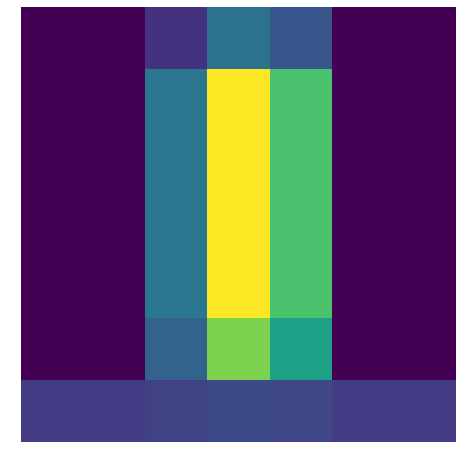

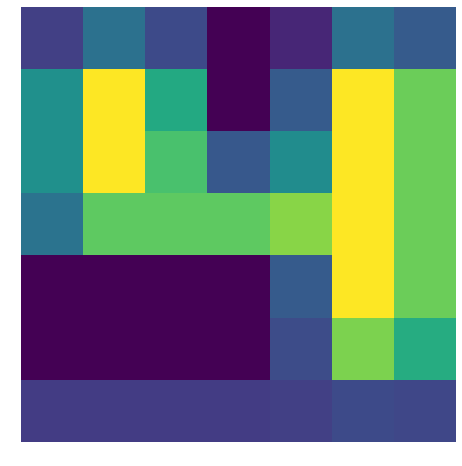

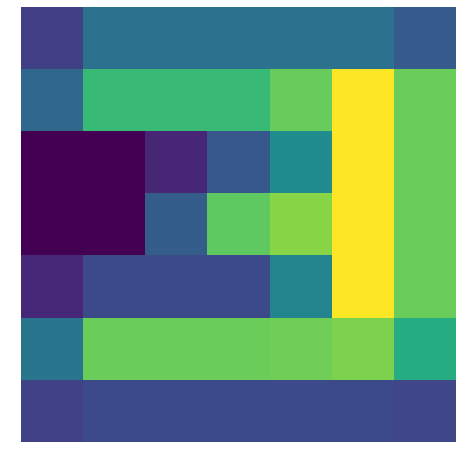

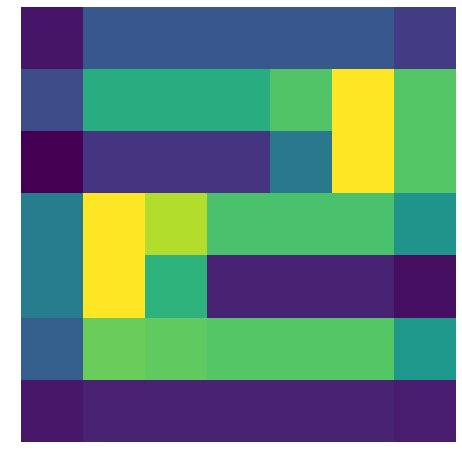

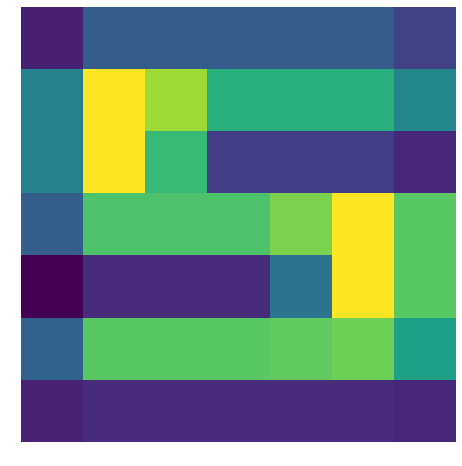

In [4]:
episodes = 1
env = gym.make("Breakout-v0")
init = env.reset()

for i in range(episodes):
    print("Welcome to AI Breakout!")
    print("Starting Test Game...\n")

    
    game = True
    LIVES = []
    while game:
        
        action = env.action_space.sample()
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        LIVES.append(lives)
        
        if done:
            
            LIVES = np.unique(np.array(LIVES), axis=0)
            
            for i in LIVES:
                plot_state(i.reshape(7,7))
            game = False
            observation = env.reset()
                             
        else:
            pass
            
         

In [5]:
env = gym.make("Breakout-v0")
init = env.reset()

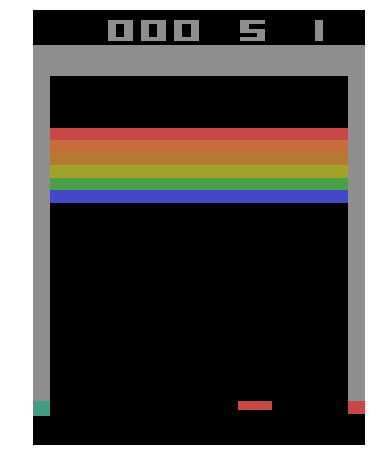

In [6]:
plot_state(init)

In [7]:
I = process_obs(init)[0]

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [8]:
I.shape

(84, 84, 1)

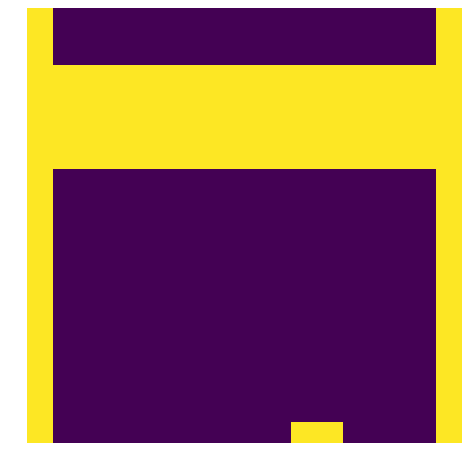

In [9]:
plot_state(I.reshape(84,84))

In [10]:
env.action_space

Discrete(4)

In [11]:
env.observation_space.shape

(210, 160, 3)

In [16]:
inp = Input(shape=(84,84,1))
x = Conv2D(16, (8,8), strides=4, activation="relu", input_shape=(84,84,1))(inp)
#x = Conv2D(32, (4,4), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dense(512,  activation="relu")(x)
#x = Dense(256, activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.01, patience=2)]
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 84, 84, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        1040      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               3277312   
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 2052      
Total params: 3,280,404
Trainable params: 3,280,404
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
LIFE = {}
LIFE["1"] = LIVES[0]
LIFE["2"] = LIVES[3]
LIFE["3"] = LIVES[2]
LIFE["4"] = LIVES[1]
LIFE["5"] = LIVES[4]

In [18]:
for i,j in LIFE.items():
    print(i)

1
2
3
4
5


In [19]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 100
episode_scores = []
epsilon = 0.3
gamma = 0.9
done = False

history = {}


for i in range(1, episodes):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    history = {"input":[], "reward":[], "action": [], "Q":[]}
    sum = 0
    frame = 0
    game = True
    LIVES = []
    while game: 
        
        if (frame == 0) or (frame % 4 == 0):
            rand = np.random.uniform(0,1)
            if  rand < epsilon:
                action = env.action_space.sample()
            else:
                observation = np.expand_dims(observation,0)
                action = np.argmax(model.predict(observation))
        else:
            pass
        
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        
        if len(LIVES) == 0:
            LIVES.append(lives)
            loss = 0
        else:
            if np.array_equal(LIVES[-1], lives):
                loss = 0
            
            else:
                LIVES.append(lives)
                loss = -2
       
        history["input"].append(observation)
        history["action"].append(action)
        history["reward"].append(2*reward + loss)
        
        sum += reward
        #time.sleep(0.001)
        #env.render()
        frame += 1
        if done:
             
            Q = []
            frame = 0
            
            for j,k in enumerate(history["reward"][::-1]):
                if j == 0:
                    val = np.array([[0, 0, 0, 0]])
                    val[0,history["action"][-1]] = k
                    Q.append(val)
                else:
                    val = np.array([[0, 0, 0, 0]])
                    val[0,history["action"][-1-j]] = k + gamma*Q[-1][0][history["action"][-j]]
                    Q.append(val)
            
            Q = np.array(Q[::-1])
            Q = Q.reshape(Q.shape[0],Q.shape[2])
            history["Q"] = Q 
            
            if len(episode_scores) == 0:
                
                print("Training the model...")
                history["input"] = np.array(history["input"])
                print(history["input"].shape)
                model.fit(history["input"], history["Q"], epochs = 1, batch_size=100, callbacks=callbacks_list)
                print("Total game score was: {}\n".format(int(sum)))
                
                observation = env.reset()
                observation, lives = process_obs(observation)
                episode_scores.append(int(sum))
                game = False
            else:
                if sum >= 0:#episode_scores[-1]:
                    print("Training the model...")
                    history["input"] = np.array(history["input"])
                    print(history["input"].shape)
                    model.fit(history["input"], history["Q"], epochs = 10, batch_size=history["input"].shape[0], callbacks=callbacks_list)
                    print("Total game score was: {}\n".format(int(sum)))
            
                    observation = env.reset()
                    observation, lives = process_obs(observation)
                    episode_scores.append(int(sum))
                    #epsilon -= 0.01
                    game = False
                else:
                    observation = env.reset()
                    observation, lives = process_obs(observation)
                    print("Total game score was: {}\n".format(int(sum)))
                    game = False 
                             
        else:
            pass
            
         

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Welcome to AI Breakout!
Starting Game 1 of 100...

Training the model...
(462, 84, 84, 1)
Epoch 1/1
462/462 [==============================] - 1s 2ms/step - loss: 0.5951 - mean_absolute_error: 0.4697
Total game score was: 1

Welcome to AI Breakout!
Starting Game 2 of 100...

Training the model...
(507, 84, 84, 1)
Epoch 1/10
507/507 [==============================] - 0s 766us/step - loss: 0.0489 - mean_absolute_error: 0.1769
Epoch 2/10
507/507 [==============================] - 0s 724us/step - loss: 0.0296 - mean_absolute_error: 0.1367
Epoch 3/10
507/507 [==============================] - 0s 747us/step - loss: 0.0165 - mean_absolute_error: 0.0794
Epoch 4/10
507/507 [==============================] - 0s 714us/step - loss: 0.0112 - mean_absolute_error: 0.0380
Epoch 5/10
507/507 [==============================] - 0s 667us/step - loss: 0.0115 - mean_absolute_error: 0.0382
Epoch 6/10
507/507 [==============================] - 0s 744us/step - loss: 0.0138 - mean_absolute_error: 0.0672
Epoch 7

Epoch 5/10
227/227 [==============================] - 0s 743us/step - loss: 0.0346 - mean_absolute_error: 0.0877
Epoch 6/10
227/227 [==============================] - 0s 818us/step - loss: 0.0346 - mean_absolute_error: 0.0877
Epoch 7/10
227/227 [==============================] - 0s 720us/step - loss: 0.0346 - mean_absolute_error: 0.0877
Epoch 8/10
227/227 [==============================] - 0s 720us/step - loss: 0.0346 - mean_absolute_error: 0.0877
Epoch 9/10
227/227 [==============================] - 0s 722us/step - loss: 0.0346 - mean_absolute_error: 0.0877
Epoch 10/10
227/227 [==============================] - 0s 715us/step - loss: 0.0346 - mean_absolute_error: 0.0877
Total game score was: 1

Welcome to AI Breakout!
Starting Game 9 of 100...

Training the model...
(165, 84, 84, 1)
Epoch 1/10
165/165 [==============================] - 0s 767us/step - loss: 0.0361 - mean_absolute_error: 0.0894
Epoch 2/10
165/165 [==============================] - 0s 822us/step - loss: 0.0361 - mean_abs

Training the model...
(160, 84, 84, 1)
Epoch 1/10
160/160 [==============================] - 0s 807us/step - loss: 0.0383 - mean_absolute_error: 0.0899
Epoch 2/10
160/160 [==============================] - 0s 795us/step - loss: 0.0383 - mean_absolute_error: 0.0899
Epoch 3/10
160/160 [==============================] - 0s 821us/step - loss: 0.0383 - mean_absolute_error: 0.0899
Epoch 4/10
160/160 [==============================] - 0s 817us/step - loss: 0.0383 - mean_absolute_error: 0.0899
Epoch 5/10
160/160 [==============================] - 0s 806us/step - loss: 0.0383 - mean_absolute_error: 0.0899
Epoch 6/10
160/160 [==============================] - 0s 803us/step - loss: 0.0383 - mean_absolute_error: 0.0899
Epoch 7/10
160/160 [==============================] - 0s 814us/step - loss: 0.0383 - mean_absolute_error: 0.0899
Epoch 8/10
160/160 [==============================] - 0s 816us/step - loss: 0.0383 - mean_absolute_error: 0.0899
Epoch 9/10
160/160 [==============================] - 0s 

274/274 [==============================] - 0s 853us/step - loss: 0.0345 - mean_absolute_error: 0.0892
Epoch 8/10
274/274 [==============================] - 0s 738us/step - loss: 0.0345 - mean_absolute_error: 0.0892
Epoch 9/10
274/274 [==============================] - 0s 709us/step - loss: 0.0345 - mean_absolute_error: 0.0892
Epoch 10/10
274/274 [==============================] - 0s 788us/step - loss: 0.0345 - mean_absolute_error: 0.0892
Total game score was: 2

Welcome to AI Breakout!
Starting Game 22 of 100...

Training the model...
(218, 84, 84, 1)
Epoch 1/10
218/218 [==============================] - 0s 763us/step - loss: 0.0360 - mean_absolute_error: 0.0881
Epoch 2/10
218/218 [==============================] - 0s 874us/step - loss: 0.0360 - mean_absolute_error: 0.0881
Epoch 3/10
218/218 [==============================] - 0s 750us/step - loss: 0.0360 - mean_absolute_error: 0.0881
Epoch 4/10
218/218 [==============================] - 0s 733us/step - loss: 0.0360 - mean_absolute_erro

Epoch 3/10
259/259 [==============================] - 0s 760us/step - loss: 0.0353 - mean_absolute_error: 0.0885
Epoch 4/10
259/259 [==============================] - 0s 731us/step - loss: 0.0353 - mean_absolute_error: 0.0885
Epoch 5/10
259/259 [==============================] - 0s 742us/step - loss: 0.0353 - mean_absolute_error: 0.0885
Epoch 6/10
259/259 [==============================] - 0s 726us/step - loss: 0.0353 - mean_absolute_error: 0.0885
Epoch 7/10
259/259 [==============================] - 0s 737us/step - loss: 0.0353 - mean_absolute_error: 0.0885
Epoch 8/10
259/259 [==============================] - 0s 734us/step - loss: 0.0353 - mean_absolute_error: 0.0885
Epoch 9/10
259/259 [==============================] - 0s 735us/step - loss: 0.0353 - mean_absolute_error: 0.0885
Epoch 10/10
259/259 [==============================] - 0s 742us/step - loss: 0.0353 - mean_absolute_error: 0.0885
Total game score was: 2

Welcome to AI Breakout!
Starting Game 29 of 100...

Training the model

Epoch 10/10
224/224 [==============================] - 0s 746us/step - loss: 0.0354 - mean_absolute_error: 0.0899
Total game score was: 1

Welcome to AI Breakout!
Starting Game 35 of 100...

Training the model...
(196, 84, 84, 1)
Epoch 1/10
196/196 [==============================] - 0s 712us/step - loss: 0.0394 - mean_absolute_error: 0.0909
Epoch 2/10
196/196 [==============================] - 0s 752us/step - loss: 0.0394 - mean_absolute_error: 0.0909
Epoch 3/10
196/196 [==============================] - 0s 752us/step - loss: 0.0394 - mean_absolute_error: 0.0909
Epoch 4/10
196/196 [==============================] - 0s 743us/step - loss: 0.0394 - mean_absolute_error: 0.0909
Epoch 5/10
196/196 [==============================] - 0s 746us/step - loss: 0.0394 - mean_absolute_error: 0.0909
Epoch 6/10
196/196 [==============================] - 0s 756us/step - loss: 0.0394 - mean_absolute_error: 0.0909
Epoch 7/10
196/196 [==============================] - 0s 753us/step - loss: 0.0394 - mean_ab

Epoch 6/10
271/271 [==============================] - 0s 732us/step - loss: 0.0340 - mean_absolute_error: 0.0884
Epoch 7/10
271/271 [==============================] - 0s 712us/step - loss: 0.0340 - mean_absolute_error: 0.0884
Epoch 8/10
271/271 [==============================] - 0s 725us/step - loss: 0.0340 - mean_absolute_error: 0.0884
Epoch 9/10
271/271 [==============================] - 0s 718us/step - loss: 0.0340 - mean_absolute_error: 0.0884
Epoch 10/10
271/271 [==============================] - 0s 726us/step - loss: 0.0340 - mean_absolute_error: 0.0884
Total game score was: 2

Welcome to AI Breakout!
Starting Game 42 of 100...

Training the model...
(258, 84, 84, 1)
Epoch 1/10
258/258 [==============================] - 0s 696us/step - loss: 0.0356 - mean_absolute_error: 0.0887
Epoch 2/10
258/258 [==============================] - 0s 730us/step - loss: 0.0356 - mean_absolute_error: 0.0887
Epoch 3/10
258/258 [==============================] - 0s 736us/step - loss: 0.0356 - mean_ab

Epoch 2/10
170/170 [==============================] - 0s 819us/step - loss: 0.0381 - mean_absolute_error: 0.0897
Epoch 3/10
170/170 [==============================] - 0s 787us/step - loss: 0.0381 - mean_absolute_error: 0.0897
Epoch 4/10
170/170 [==============================] - 0s 833us/step - loss: 0.0381 - mean_absolute_error: 0.0897
Epoch 5/10
170/170 [==============================] - 0s 783us/step - loss: 0.0381 - mean_absolute_error: 0.0897
Epoch 6/10
170/170 [==============================] - 0s 798us/step - loss: 0.0381 - mean_absolute_error: 0.0897
Epoch 7/10
170/170 [==============================] - 0s 798us/step - loss: 0.0381 - mean_absolute_error: 0.0897
Epoch 8/10
170/170 [==============================] - 0s 798us/step - loss: 0.0381 - mean_absolute_error: 0.0897
Epoch 9/10
170/170 [==============================] - 0s 805us/step - loss: 0.0381 - mean_absolute_error: 0.0897
Epoch 10/10
170/170 [==============================] - 0s 980us/step - loss: 0.0381 - mean_absol

Epoch 9/10
229/229 [==============================] - 0s 735us/step - loss: 0.0346 - mean_absolute_error: 0.0877
Epoch 10/10
229/229 [==============================] - 0s 728us/step - loss: 0.0346 - mean_absolute_error: 0.0877
Total game score was: 1

Welcome to AI Breakout!
Starting Game 55 of 100...

Training the model...
(266, 84, 84, 1)
Epoch 1/10
266/266 [==============================] - 0s 709us/step - loss: 0.0339 - mean_absolute_error: 0.0879
Epoch 2/10
266/266 [==============================] - 0s 720us/step - loss: 0.0339 - mean_absolute_error: 0.0879
Epoch 3/10
266/266 [==============================] - 0s 737us/step - loss: 0.0339 - mean_absolute_error: 0.0879
Epoch 4/10
266/266 [==============================] - 0s 728us/step - loss: 0.0339 - mean_absolute_error: 0.0879
Epoch 5/10
266/266 [==============================] - 0s 724us/step - loss: 0.0339 - mean_absolute_error: 0.0879
Epoch 6/10
266/266 [==============================] - 0s 724us/step - loss: 0.0339 - mean_ab

Epoch 5/10
233/233 [==============================] - 0s 736us/step - loss: 0.0332 - mean_absolute_error: 0.0886
Epoch 6/10
233/233 [==============================] - 0s 718us/step - loss: 0.0332 - mean_absolute_error: 0.0886
Epoch 7/10
233/233 [==============================] - 0s 712us/step - loss: 0.0332 - mean_absolute_error: 0.0886
Epoch 8/10
233/233 [==============================] - 0s 717us/step - loss: 0.0332 - mean_absolute_error: 0.0886
Epoch 9/10
233/233 [==============================] - 0s 715us/step - loss: 0.0332 - mean_absolute_error: 0.0886
Epoch 10/10
233/233 [==============================] - 0s 716us/step - loss: 0.0332 - mean_absolute_error: 0.0886
Total game score was: 1

Welcome to AI Breakout!
Starting Game 62 of 100...

Training the model...
(237, 84, 84, 1)
Epoch 1/10
237/237 [==============================] - 0s 699us/step - loss: 0.0322 - mean_absolute_error: 0.0868
Epoch 2/10
237/237 [==============================] - 0s 728us/step - loss: 0.0322 - mean_ab

Training the model...
(165, 84, 84, 1)
Epoch 1/10
165/165 [==============================] - 0s 731us/step - loss: 0.0389 - mean_absolute_error: 0.0902
Epoch 2/10
165/165 [==============================] - 0s 819us/step - loss: 0.0389 - mean_absolute_error: 0.0902
Epoch 3/10
165/165 [==============================] - 0s 799us/step - loss: 0.0389 - mean_absolute_error: 0.0902
Epoch 4/10
165/165 [==============================] - 0s 868us/step - loss: 0.0389 - mean_absolute_error: 0.0902
Epoch 5/10
165/165 [==============================] - 0s 804us/step - loss: 0.0389 - mean_absolute_error: 0.0902
Epoch 6/10
165/165 [==============================] - 0s 816us/step - loss: 0.0389 - mean_absolute_error: 0.0902
Epoch 7/10
165/165 [==============================] - 0s 812us/step - loss: 0.0389 - mean_absolute_error: 0.0902
Epoch 8/10
165/165 [==============================] - 0s 819us/step - loss: 0.0389 - mean_absolute_error: 0.0902
Epoch 9/10
165/165 [==============================] - 0s 

Epoch 7/10
271/271 [==============================] - 0s 765us/step - loss: 0.0342 - mean_absolute_error: 0.0885
Epoch 8/10
271/271 [==============================] - 0s 708us/step - loss: 0.0342 - mean_absolute_error: 0.0885
Epoch 9/10
271/271 [==============================] - 0s 856us/step - loss: 0.0342 - mean_absolute_error: 0.0885
Epoch 10/10
271/271 [==============================] - 0s 739us/step - loss: 0.0342 - mean_absolute_error: 0.0885
Total game score was: 2

Welcome to AI Breakout!
Starting Game 75 of 100...

Training the model...
(165, 84, 84, 1)
Epoch 1/10
165/165 [==============================] - 0s 881us/step - loss: 0.0376 - mean_absolute_error: 0.0898
Epoch 2/10
165/165 [==============================] - 0s 904us/step - loss: 0.0376 - mean_absolute_error: 0.0898
Epoch 3/10
165/165 [==============================] - 0s 964us/step - loss: 0.0376 - mean_absolute_error: 0.0898
Epoch 4/10
165/165 [==============================] - 0s 947us/step - loss: 0.0376 - mean_ab

Epoch 3/10
202/202 [==============================] - 0s 1ms/step - loss: 0.0384 - mean_absolute_error: 0.0900
Epoch 4/10
202/202 [==============================] - 0s 932us/step - loss: 0.0384 - mean_absolute_error: 0.0900
Epoch 5/10
202/202 [==============================] - 0s 990us/step - loss: 0.0384 - mean_absolute_error: 0.0900
Epoch 6/10
202/202 [==============================] - 0s 934us/step - loss: 0.0384 - mean_absolute_error: 0.0900
Epoch 7/10
202/202 [==============================] - 0s 932us/step - loss: 0.0384 - mean_absolute_error: 0.0900
Epoch 8/10
202/202 [==============================] - 0s 913us/step - loss: 0.0384 - mean_absolute_error: 0.0900
Epoch 9/10
202/202 [==============================] - 0s 772us/step - loss: 0.0384 - mean_absolute_error: 0.0900
Epoch 10/10
202/202 [==============================] - 0s 742us/step - loss: 0.0384 - mean_absolute_error: 0.0900
Total game score was: 1

Welcome to AI Breakout!
Starting Game 82 of 100...

Training the model..

Epoch 10/10
224/224 [==============================] - 0s 722us/step - loss: 0.0354 - mean_absolute_error: 0.0897
Total game score was: 1

Welcome to AI Breakout!
Starting Game 88 of 100...

Training the model...
(303, 84, 84, 1)
Epoch 1/10
303/303 [==============================] - 0s 721us/step - loss: 0.0357 - mean_absolute_error: 0.0888
Epoch 2/10
303/303 [==============================] - 0s 668us/step - loss: 0.0357 - mean_absolute_error: 0.0888
Epoch 3/10
303/303 [==============================] - 0s 742us/step - loss: 0.0357 - mean_absolute_error: 0.0888
Epoch 4/10
303/303 [==============================] - 0s 798us/step - loss: 0.0357 - mean_absolute_error: 0.0888
Epoch 5/10
303/303 [==============================] - 0s 746us/step - loss: 0.0357 - mean_absolute_error: 0.0888
Epoch 6/10
303/303 [==============================] - 0s 697us/step - loss: 0.0357 - mean_absolute_error: 0.0888
Epoch 7/10
303/303 [==============================] - 0s 735us/step - loss: 0.0357 - mean_ab

Epoch 6/10
408/408 [==============================] - 0s 750us/step - loss: 0.0330 - mean_absolute_error: 0.0887
Epoch 7/10
408/408 [==============================] - 0s 671us/step - loss: 0.0330 - mean_absolute_error: 0.0887
Epoch 8/10
408/408 [==============================] - 0s 709us/step - loss: 0.0330 - mean_absolute_error: 0.0887
Epoch 9/10
408/408 [==============================] - 0s 655us/step - loss: 0.0330 - mean_absolute_error: 0.0887
Epoch 10/10
408/408 [==============================] - 0s 874us/step - loss: 0.0330 - mean_absolute_error: 0.0887
Total game score was: 5

Welcome to AI Breakout!
Starting Game 95 of 100...

Training the model...
(160, 84, 84, 1)
Epoch 1/10
160/160 [==============================] - 0s 1ms/step - loss: 0.0403 - mean_absolute_error: 0.0913
Epoch 2/10
160/160 [==============================] - 0s 1ms/step - loss: 0.0403 - mean_absolute_error: 0.0913
Epoch 3/10
160/160 [==============================] - 0s 1ms/step - loss: 0.0403 - mean_absolute

In [20]:
observation.shape

(84, 84, 1)

# Saving Model

In [21]:
model.save("breakout-atari-rl.h5")

# Testing the Model

In [22]:
mod = load_model("breakout-atari-rl.h5")

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


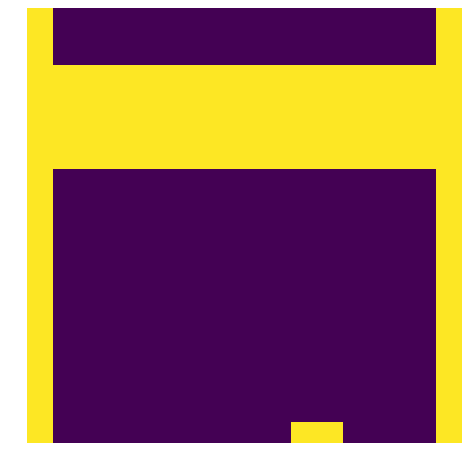

Welcome to AI Breakout!
Starting Game 1 of 20...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 2 of 20...


KeyboardInterrupt: 

In [23]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

plot_state(observation.reshape((84,84)))

episodes = 20
done = False
epsilon = 0


for i in range(1, episodes):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    game = True
    obs = []
    while game:
        
        if (len(obs) == 0):
            action = 1
        elif (len(obs) > 1) and (np.array_equal(obs[-1],obs[-2])):
            action = 1
        else:
            rand = np.random.uniform(0,1)
            if  rand < epsilon:
                action = env.action_space.sample()
            else:
                observation = np.expand_dims(observation,0)
                action = np.argmax(mod.predict(observation))
            
        #print(action)
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        obs.append(observation)

        sum += reward
        time.sleep(0.05)
        env.render()

        if done:
            print("Total game score was: {}\n".format(sum))
            observation = env.reset()
            observation, lives = process_obs(observation)
            game = False
env.close()        

In [ ]:
observation

In [ ]:
history["input"].shape[0]